In [1]:
!pip install svgpath2mpl

In [2]:
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adamax
import random
import math 
from svgpath2mpl import parse_path
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import rotate, shift
from abc import ABCMeta, abstractmethod
from matplotlib.animation import FuncAnimation

In [3]:
class AbstactFireEnv(metaclass = ABCMeta):

  def __init__(self, _height, _width, _episode_length=250):
      self._episode_length = _episode_length
      self._height = _height
      self._width  = _width
      self._time_steps = 0
      self._observation = None

  @property
  def height(self):
    return self._height
  
  @property
  def width(self):
    return self._width

  @property 
  def time_steps(self):
    return self._time_steps

  @time_steps.setter
  def time_steps(self, _time_steps):
    self._time_steps = _time_steps

  @property
  def observation(self):
    return self._observation

  @observation.setter
  def observation(self, _observation):
    self._observation = _observation

  def step(self):
    self._time_steps += 1
    done = self._episode_length == self._time_steps
    self.observation = self.next_observation()
    return self.observation, done

  def plot_heat_map(self, fig, ax):
    ax.axis(xmin=0, xmax=self._width)
    ax.axis(ymin=0, ymax=self._height)  
    heat_map_plot = ax.imshow(self.observation, cmap='hot')
    return heat_map_plot

  def reset(self):
    self._time_steps = 0
    self.observation = self.reset_observation()
    return self.observation

  @abstractmethod
  def next_observation(self):
    pass

  @abstractmethod
  def reset_observation(self):
    pass

In [4]:
height = 100
width = 100
D = 2
K = 0.05

def getNeighbors(point):
    neighbors = []
    min_x = max(0, point[1]-D)
    max_x = min(99, point[1]+D)
    min_y = max(0, point[0]-D)
    max_y = min(99, point[0]+D)

    for y in range(min_y, max_y): 
      for x in range(min_x, max_x):
        neighbors.append((y, x))
    return neighbors

class ProbabilisticFireEnv(AbstactFireEnv):

  def next_observation(self):

    probability_map = np.zeros(shape=(height,width), dtype=float)
    for row in range(self.height):
      for col in range(self.width):
        if self.observation[row,col] == 1:
          if self.fuel[row, col] > 0:
            self.fuel[row, col] -= 1
          else:
            self.observation[row,col] = 0

        elif self.observation[row,col] == 0 and self.fuel[row, col] > 0:
          neighboring_cells = getNeighbors((row, col))
          pnm = 1
          for neighboring_cell in neighboring_cells:
            if self.observation[neighboring_cell] == 1:
              dnmkl = np.array([a-b for a, b in zip(neighboring_cell, (row,col))])
              norm = np.sum(dnmkl**2)
              pnmkl0 = K/norm
              pnmklw = K*(dnmkl @ self.wind)/norm 
              pnmkl  = max(0, min(1, (pnmkl0+pnmklw)))
              pnm *= (1-pnmkl)
          pmn = 1 - pnm
          probability_map[row, col] = pmn

    for row in range(self.height):
      for col in range(self.width):
        if probability_map[row, col] > random.random():
          self.observation[row, col] = 1

    return self.observation

  def reset_observation(self):
    center = [49, 49]
    self.observation = np.zeros(shape=(self.height, self.width), dtype=int)
    self.observation[center[0]-2:center[0]+2, center[1]-2:center[1]+2] = 1
    self.fuel = np.random.randint(low=15, high=20, size=(self.height, self.width))
    self.wind = np.random.uniform(low=-0.25, high=0.25, size=2)
    return self.observation

In [5]:
LAMBDA_1 = 0.35
LAMBDA_2 = 0.35
LAMBDA_3 = 0.15
LAMBDA_4 = 0.15 
C = 50
Cx = 50
Cy = 50

VELOCITY = 2
GRAVITY  = 0.981
MINRANGE = 15   # Minimium initial distance from wildfire seed
MAXRANGE = 30   # Maximum initial distance from wildfire seed
BANK_ANGLE_DELTA  = 5

plane_marker = parse_path('M 11.640625 15.0625 L 9.304688 13.015625 L 9.300781 9.621094 L 15.125 11.511719 L 15.117188 10.109375 L 9.257812 5.535156 L 9.25 2.851562 L 9.25 1.296875 C 9.253906 1.019531 9.140625 0.777344 8.960938 0.585938 C 8.738281 0.324219 8.410156 0.15625 8.039062 0.160156 C 8.027344 0.160156 8.011719 0.164062 8 0.164062 C 7.988281 0.164062 7.972656 0.160156 7.960938 0.160156 C 7.589844 0.15625 7.257812 0.324219 7.035156 0.585938 C 6.859375 0.777344 6.746094 1.019531 6.746094 1.296875 L 6.746094 2.851562 L 6.742188 5.535156 L 0.882812 10.109375 L 0.875 11.511719 L 6.699219 9.621094 L 6.691406 13.011719 L 4.359375 15.0625 L 4.355469 15.761719 L 4.628906 15.695312 L 4.628906 15.839844 L 7.511719 14.992188 L 8 14.875 L 8.484375 14.992188 L 11.371094 15.839844 L 11.375 15.695312 L 11.644531 15.761719 Z M 11.640625 15.0625 ')
plane_marker.vertices -= plane_marker.vertices.mean(axis=0)
#plane_marker = plane_marker.transformed(matplotlib.transforms.Affine2D().rotate_deg(180))

def euclidean_distance(x1, y1, x2, y2):
  return math.sqrt((x2-x1)**2+(y2-y1)**2)

def shift_matrix(matrix, x, y, padding_value=0):
  deltaX = Cx-x
  deltaY = Cy-y


  if deltaX==0 and deltaY==0:
    return matrix

  return shift(matrix, (deltaY, deltaX), cval = padding_value)
  

class Drone:

  def __init__(self, _droneEnv):
    self._bank_angle = 0
    self._droneEnv = _droneEnv
    self._trajectory = []
    self._otherDrone = None

  def reset(self):
    radius = random.random()*(MAXRANGE-MINRANGE) + MINRANGE
    angle = (random.random()-0.5)*2*np.pi
    self._x = radius*np.cos(angle) + 50
    self._y = radius*np.sin(angle) + 50
    self._bank_angle = 0
    self._trajectory = [(self.x, self.y)]
    self._heading_angle = (random.random()-0.5)*2*np.pi

  @property
  def otherDrone(self):
    return self._otherDrone

  @otherDrone.setter
  def otherDrone(self, _otherDrone):
    self._otherDrone = _otherDrone

  @property
  def trajectory(self):
    return self._trajectory

  @trajectory.setter
  def trajectory(self, _trajectory):
    self._trajectory = _trajectory

  @property
  def x(self):
    return self._x

  @x.setter
  def x(self, _x):
    self._x = _x

  @property
  def y(self):
    return self._y

  @y.setter
  def y(self, _y):
    self._y = _y


  @property
  def bank_angle(self):
    return self._bank_angle

  @bank_angle.setter
  def bank_angle(self, _bank_angle):
    self._bank_angle = _bank_angle

  @property
  def heading_angle(self):
    return self._heading_angle

  @heading_angle.setter
  def heading_angle(self, _heading_angle):
    self._heading_angle = _heading_angle
  
  @property
  def rho(self):
    return euclidean_distance(self.x, self.y, self.otherDrone.x, self.otherDrone.y)

  @property
  def theta(self):
    _theta = np.arctan2((self.otherDrone.y-self.y),(self.otherDrone.x-self.x)) - self.heading_angle
    
    if (_theta > math.pi):
      _theta -= 2*math.pi
    elif (_theta<-math.pi):
      _theta+= 2*math.pi

    return _theta

  @property
  def psi(self):
    _psi = self.otherDrone.heading_angle - self.heading_angle

    if (_psi > math.pi):
      _psi -= 2*math.pi
    elif (_psi<-math.pi):
      _psi += 2*math.pi

    return _psi
    
  @property
  def state(self):
    return np.array([
        np.deg2rad(self.bank_angle), 
        self.rho,
        self.theta,
        self.psi,
        np.deg2rad(self.otherDrone.bank_angle) 
    ])[np.newaxis,...]

  @property
  def belief_map(self):
    return self._transform_map(self._droneEnv.belief_map_channel.copy())
  
  @property
  def time_elasped_map(self):
    return self._transform_map(self._droneEnv.time_map_channel.copy(), 250.0)/250.0

  def _transform_map(self, map, padding_value=0):
    #matrix = rotate(map, angle=np.rad2deg(self.heading_angle), reshape=False, cval=padding_value)
    #return matrix[int(self.y)-50:int(self.y)+50, int(self.x)-50:int(self.x)+50]
    #return shift_matrix(rotate(map, angle=np.rad2deg(self.heading_angle), cval=padding_value), self.x, self.y, padding_value)
    return rotate(shift_matrix(map, self.x, self.y, padding_value), angle=np.rad2deg(self.heading_angle), reshape=False, cval=padding_value)
    #return rotate(map, angle=np.rad2deg(self.heading_angle), reshape=False, cval=padding_value )
  @property
  def observation(self):
    return np.stack((self.time_elasped_map, self.belief_map), axis=0)[np.newaxis,...]
    
  def step(self, input):
    bank_angle_delta =  5 if input==1 else -5

    if abs(self._bank_angle + bank_angle_delta) <= 50:

      self._bank_angle = self._bank_angle + bank_angle_delta 
      self.heading_angle = self.heading_angle + GRAVITY*np.tan(np.deg2rad(self.bank_angle))/(VELOCITY)

      self._x = self._x +  VELOCITY*math.cos(self.heading_angle)
      self._y = self._y +  VELOCITY*math.sin(self.heading_angle)   

      if (self.heading_angle>math.pi):
        self.heading_angle-=2*math.pi
      elif (self.heading_angle<-math.pi):
        self.heading_angle+=2*math.pi

      self.trajectory.append((self._x, self._y))

  @property
  def reward(self):

    return self._reward1()+self._reward2()+self._reward3()+self._reward4()
      

  def _reward1(self):
    
    fire_points = np.argwhere(self._droneEnv.belief_map_channel == 1)

    if len(fire_points) == 0:
      return -LAMBDA_1*141.42
    else:
      euclidean_distances = [euclidean_distance(self.x, self.y, fire_point[1], fire_point[0]) for fire_point in fire_points]
      return -LAMBDA_1*min(euclidean_distances) 


  def _reward2(self):

    min_drone_y = int(max(self.y-self._droneEnv.scan_radius,0))
    max_drone_y = int(min(self.y+self._droneEnv.scan_radius, height))

    min_drone_x = int(max(self.x-self._droneEnv.scan_radius,0))
    max_drone_x = int(min(self.x+self._droneEnv.scan_radius, width))
    
    radar = self._droneEnv.belief_map_channel[min_drone_y:max_drone_y,min_drone_x:max_drone_x]
    return -LAMBDA_2*(np.count_nonzero(radar==0))

  def _reward3(self):
    return -LAMBDA_3*(np.deg2rad(self.bank_angle)**2)

  def _reward4(self):
    return -LAMBDA_4*math.exp(-self.rho/C)

  def plot_time_elapsed(self, fig, ax):

    ax.axis(xmin=0, xmax=width)
    ax.axis(ymin=0, ymax=height)
    time_elasped_plot = ax.imshow(self.time_elasped_map*250.0, cmap='gray', vmin=0, vmax=250)
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(time_elasped_plot, cax=cax)
    return time_elasped_plot 

  def plot_belief_map(self, fig, ax):

    ax.axis(xmin=0, xmax=width)
    ax.axis(ymin=0, ymax=height)
    belief_map_plot = ax.imshow(self.belief_map, cmap='gray_r', vmin=0, vmax=1)  
    return belief_map_plot


class DronesEnv:
  def __init__(self, _height, _width, _scan_radius=10, _threshold=0.1):
    self._drones = [Drone(self), Drone(self)]
    self._drones[0].otherDrone = self._drones[1]
    self._drones[1].otherDrone = self._drones[0]
    self._height = _height 
    self._width  = _width
    self._scan_radius = _scan_radius
    self._threshold = _threshold

  @property 
  def scan_radius(self):
    return self._scan_radius

  @scan_radius.setter
  def scan_radius(self, _scan_radius):
    self._scan_radius = _scan_radius
        
  def reset(self, fireMap=np.nan):


    self._drones[0].reset()
    self._drones[1].reset()

    self._belief_map_channel = fireMap.copy()
    #self._belief_map_channel = np.zeros(shape=(self._height, self._width))
    self._time_elapsed_channel = np.full(shape=(self._height, self._width), fill_value=250)

    self._drone_scan(self._drones[0], fireMap)
    self._drone_scan(self._drones[1], fireMap)


    
  def _drone_scan(self, drone, fireMap=np.nan):
    
    reward = 0

    min_drone_y = int(max(drone.y-self._scan_radius,0))
    max_drone_y = int(min(drone.y+self._scan_radius, self._height))

    min_drone_x = int(max(drone.x-self._scan_radius,0))
    max_drone_x = int(min(drone.x+self._scan_radius, self._width))

    if fireMap.any() != np.nan:
      for y in range(min_drone_y,  max_drone_y):
        for x in range(min_drone_x,  max_drone_x):
          if fireMap[y,x] == 1 and self._belief_map_channel[y,x] == 0:
            reward += 1
          self._belief_map_channel[y,x] = fireMap[y,x]
            
    mask = np.ones(shape=(self._height, self._width), dtype=bool)
    mask[:] = False
    mask[min_drone_y:max_drone_y, min_drone_x:max_drone_x] = True

    self._time_elapsed_channel[mask] = 0

    self._time_elapsed_channel[~mask & (self._time_elapsed_channel < 250)] += 1

    return reward

  @property 
  def belief_map_channel(self):
    return self._belief_map_channel

  @belief_map_channel.setter
  def belief_map_channel(self, _belief_map_channel):
    self._belief_map_channel = _belief_map_channel

  @property 
  def time_map_channel(self):
    return self._time_elapsed_channel

  @time_map_channel.setter
  def time_map_channel(self, _time_elapsed_channel):
    self._time_elapsed_channel = _time_elapsed_channel

  @property
  def drones(self):
    return self._drones

  def step(self, input, fireMap):
    self._drones[0].step(input[0])
    self._drones[1].step(input[1])
    reward1 = self._drone_scan(self._drones[0], fireMap)
    reward2 = self._drone_scan(self._drones[1], fireMap)
    return reward1, reward2

  def plot_time_elapsed(self, fig, ax):
    ax.axis(xmin=0, xmax=width)
    ax.axis(ymin=0, ymax=height)
    time_elasped_plot = ax.imshow(self._time_elapsed_channel, cmap='gray', vmin=0, vmax=250)
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(time_elasped_plot, cax=cax)
    return time_elasped_plot

  def plot_belief_map(self, fig, ax):
    ax.axis(xmin=0, xmax=width)
    ax.axis(ymin=0, ymax=height)
    belief_map_plot = ax.imshow(self._belief_map_channel, cmap='gray_r', vmin=0, vmax=1)
    return belief_map_plot   

  def plot_drones(self, fig, ax):
      
    ax.axis(xmin=0, xmax=self._width)
    ax.axis(ymin=0, ymax=self._height)
    ax.set_aspect(1)
    ax.grid()

    plane_marker_1 = matplotlib.markers.MarkerStyle(marker=plane_marker)
    plane_marker_1._transform = plane_marker_1.get_transform().rotate(self.drones[0].heading_angle)

    plane_marker_2 = matplotlib.markers.MarkerStyle(marker=plane_marker)
    plane_marker_2._transform = plane_marker_2.get_transform().rotate(self.drones[1].heading_angle)

    ax.scatter(self.drones[0].x, self.drones[0].y, marker=plane_marker_1, s=30**2)

    ax.scatter(self.drones[1].x, self.drones[1].y, marker=plane_marker_2, s=30**2)

    heading_line = np.array([0, 50])

    x1 = self._drones[0].x + np.cos(np.deg2rad(-90) + self._drones[0].heading_angle) * heading_line
    y1 = self._drones[0].y + np.sin(np.deg2rad(-90) + self._drones[0].heading_angle) * heading_line

    heading_line = np.array([0, 50])

    x2 = self._drones[1].x + np.cos(np.deg2rad(-90) + self._drones[1].heading_angle) * heading_line
    y2 = self._drones[1].y + np.sin(np.deg2rad(-90) + self._drones[1].heading_angle) * heading_line
    
    ax.plot(x1, y1, '--')
    ax.plot(x2, y2, '--')

  def plot_trajectory(self, fig, ax):
      
    ax.axis(xmin=0, xmax=self._width)
    ax.axis(ymin=0, ymax=self._height)
    ax.set_aspect(1)
    ax.grid()

    plane_marker_1 = matplotlib.markers.MarkerStyle(marker=plane_marker)
    plane_marker_1._transform = plane_marker_1.get_transform().rotate(self._drones[0].heading_angle)

    plane_marker_2 = matplotlib.markers.MarkerStyle(marker=plane_marker)
    plane_marker_2._transform = plane_marker_2.get_transform().rotate(self._drones[1].heading_angle)

    ax.scatter(self.drones[0].x, self.drones[0].y, marker=plane_marker_1, s=30**2)

    ax.scatter(self.drones[1].x, self.drones[1].y, marker=plane_marker_2, s=30**2)

    x1, y1 = zip(*self.drones[0].trajectory)
    x2, y2 = zip(*self.drones[1].trajectory)

    ax.plot(x1, y1, '.')
    ax.plot(x2, y2, '.')

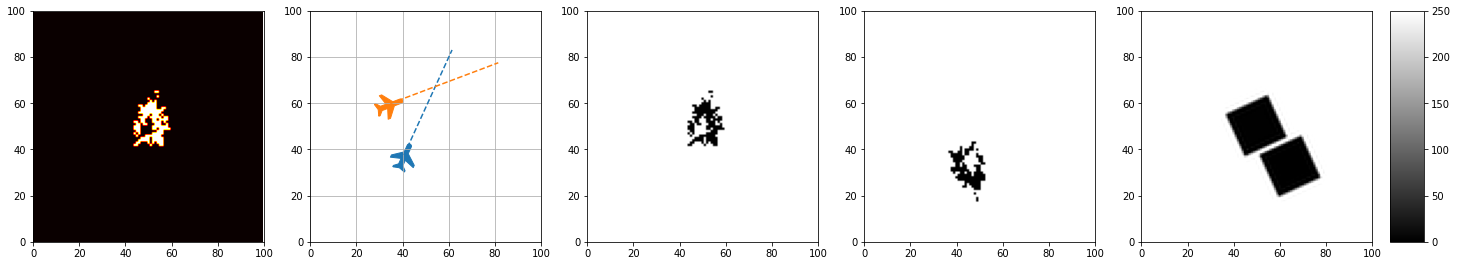

In [6]:

fireEnv = ProbabilisticFireEnv(height, width)
observation = fireEnv.reset()
for _ in range(25):
    observation, done = fireEnv.step()
dronesEnv = DronesEnv(height, width) 
dronesEnv.reset(observation)


fig, ax = plt.subplots(1, 5, figsize=(24,12))
fireEnv.plot_heat_map(fig, ax[0])
dronesEnv.plot_drones(fig, ax[1])
dronesEnv.plot_belief_map(fig, ax[2])
dronesEnv.drones[0].plot_belief_map(fig, ax[3])
dronesEnv.drones[0].plot_time_elapsed(fig, ax[4])

In [7]:
Transition = namedtuple('Transition',('belief_map', 'state_vector', 'action', 'next_belief_map', 'next_state_vector', 'reward'))
class ReplayMemory:

  def __init__(self, capacity):
    self.capicity = capacity
    self.memory = deque([],maxlen=self.capicity)

  def push(self, *args):
    """Save a transition"""
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [8]:
class DQN(nn.Module):

  def _get_conv_out(self, shape):
    o = self.conv(torch.zeros(1, *shape))
    return int(np.prod(o.size()))

  def __init__(self, channels, height, width, outputs):
    super(DQN, self).__init__()

    self.fc1  = nn.Sequential(
      nn.Linear(5, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU()
    )

    self.conv = nn.Sequential(
      nn.Conv2d(2, 64, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2)
    )
  
    conv_out_size = self._get_conv_out((channels,height,width))

    self.fc2 = nn.Sequential(
      nn.Linear(conv_out_size, 500),
      nn.ReLU(),
      nn.Linear(500, 100),
      nn.ReLU(),
    )

    self.fc3 = nn.Sequential(
      nn.Linear(200, 200),
      nn.ReLU(),
      nn.Linear(200, 2),
    )


  def forward(self, belief_map, state_vector):
    fc1_out = self.fc1(state_vector)
    conv_out = torch.flatten(self.conv(belief_map),1)
    fc2_out = self.fc2(conv_out)
    fc3_out = self.fc3(torch.cat((fc1_out, fc2_out), dim=1))
    return fc3_out

In [9]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.10
EPS_DECAY = 150000
INIT_SIZE = 35000
TARGET_UPDATE = 1000
SAVE_POLICY = 100
EPISODE_LENGTH = 250

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_actions = 2
screen_height = screen_width = 100
channels = 2
policy_net = DQN(channels, screen_height, screen_width, n_actions).to(device)
target_net = DQN(channels, screen_height, screen_width, n_actions).to(device)
steps = 0
policy_file_path = f'./policy_weights.pt'
target_file_path = f'./target_weights.pt'

#policy_net.load_state_dict(torch.load(policy_file_path))
#target_net.load_state_dict(torch.load('target_weights.pt'))
target_net.load_state_dict(policy_net.state_dict())
memory = ReplayMemory(70000)
#memory.load()
policy_net.train()
target_net.eval()

optimizer = Adamax(policy_net.parameters(), lr=0.0001)


episode_durations = []

In [11]:
def select_action(belief_map, state_vector, steps):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
      math.exp(-1. * steps / EPS_DECAY)

    if sample > eps_threshold:
      with torch.no_grad():
        output = policy_net(belief_map, state_vector).max(1)[1].view(1, 1)
        return output
    else:
      return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)

In [12]:
def optimize_model():
    

    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    next_states = torch.cat(batch.next_state_vector)
    next_belief_map = torch.cat(batch.next_belief_map)

    belief_map_batch = torch.cat(batch.belief_map)
    state_vector_batch = torch.cat(batch.state_vector)
    
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(belief_map_batch, state_vector_batch).gather(1, action_batch)

    next_state_values = target_net(next_belief_map, next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss().to(device)
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss

In [13]:

fireEnv = ProbabilisticFireEnv(height, width)
AMOUNT_OF_EPISODES = 4000
dronesEnv = DronesEnv(height, width) 
loss = None
for i_episode in range(AMOUNT_OF_EPISODES):
  # Initialize the environment and state
  #env.reset()
  done = False
  observation = fireEnv.reset()
  dronesEnv.reset(observation)
  
  state_vector_1 = dronesEnv.drones[0].state
  map_1 = dronesEnv.drones[0].observation
  state_vector_1 = torch.tensor(state_vector_1, device=device, dtype=torch.float)
  map_1 = torch.tensor(map_1, device=device, dtype=torch.float)

  state_vector_2 = dronesEnv.drones[1].state
  map_2 = dronesEnv.drones[1].observation
  state_vector_2 = torch.tensor(state_vector_2, device=device, dtype=torch.float)
  map_2 = torch.tensor(map_2, device=device, dtype=torch.float)
  
  for _ in range(25):
    fireEnv.step()
  
  seconds = 0

  while seconds < 250:
    # Select and perform an action

    action1 = select_action(map_1, state_vector_1, steps)
    action2 = select_action(map_2, state_vector_2, steps)
    steps += 2
    seconds += 1
    reward_1, reward_2 = dronesEnv.step([action1.item(), action2.item()], observation)
    
    next_state_vector_1 = dronesEnv.drones[0].state
    next_map_1 = dronesEnv.drones[0].observation

    next_state_vector_1 = torch.tensor(next_state_vector_1, device=device, dtype=torch.float)
    next_map_1 = torch.tensor(next_map_1, device=device, dtype=torch.float)

    next_state_vector_2 = dronesEnv.drones[1].state
    next_map_2 = dronesEnv.drones[1].observation

    next_state_vector_2 = torch.tensor(next_state_vector_2, device=device, dtype=torch.float)
    next_map_2 = torch.tensor(next_map_2, device=device, dtype=torch.float)

    reward_1 = torch.tensor([reward_1], device=device)
    reward_2 = torch.tensor([reward_2], device=device)   

    # Store the transition in memory      
    memory.push(map_1, state_vector_1, action1, next_map_1, next_state_vector_1, reward_1)
    memory.push(map_2, state_vector_2, action2, next_map_2, next_state_vector_2, reward_2)

    # Move to the next state
    state_vector_1 = next_state_vector_1
    state_vector_2 = next_state_vector_2

    map_1 = next_map_1
    map_2 = next_map_2

    if seconds % 5 == 0:
        observation, done = fireEnv.step()

  if (i_episode+1) % TARGET_UPDATE == 0:
    policy_file_path = f'./policy_weights.pt'
    target_file_path = f'./target_weights.pt'
    #memory.save()
    torch.save(policy_net.state_dict(), policy_file_path)
    torch.save(target_net.state_dict(), target_file_path)
    print('update target')
    target_net.load_state_dict(policy_net.state_dict())
  if (i_episode+1) % 25 == 0:
    print(f'{i_episode+1} episodes completed')

  if len(memory) >= INIT_SIZE:
    loss = optimize_model()
    print(f'loss {loss}')
    print(f'steps done {steps}')

25 episodes completed
50 episodes completed
loss 0.7084856033325195
steps done 35000
loss 0.6219800710678101
steps done 35500
loss 0.3013077974319458
steps done 36000
loss 0.6354987621307373
steps done 36500
loss 0.7913836240768433
steps done 37000
75 episodes completed
loss 0.35052943229675293
steps done 37500
loss 0.9044079780578613
steps done 38000
loss 1.0220370292663574
steps done 38500
loss 1.086061954498291
steps done 39000
loss 0.4583699405193329
steps done 39500
loss 0.7675681114196777
steps done 40000
loss 0.7595455050468445
steps done 40500
loss 0.827163577079773
steps done 41000
loss 0.684453010559082
steps done 41500
loss 0.4874804615974426
steps done 42000
loss 0.746406614780426
steps done 42500
loss 0.2260417342185974
steps done 43000
loss 0.4119229316711426
steps done 43500
loss 0.6220840215682983
steps done 44000
loss 0.7317930459976196
steps done 44500
loss 0.8784646391868591
steps done 45000
